In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [4]:
file_path = 'Original data/train.csv'
data = pd.read_csv(file_path)
data['Target'] = data['Target'].map({'Graduate': 1, 'Dropout': 2, 'Enrolled': 0})

# Exploratory data analysis

## 1. Categorize all factors into 5 groups

In [5]:
feature_groups = {
    'Demographic': ['Marital status', 'Nacionality', 'Displaced', 'Gender', 'Age at enrollment', 'International'],
    'Socioeconomic': [
        "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation",
        'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Scholarship holder'
    ],
    'Macroeconomic': ['Unemployment rate', 'Inflation rate', 'GDP'],
    'Academic Enrollment': [
        'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification'
    ],
    'Academic Performance': [
        'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)',
        'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)',
        'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)',
        'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)',
        'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)',
        'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)'
    ]
}

In [6]:
# store correlation result
group_correlation_results = {}

# store group mean
category_mean_correlations = {}

# Traverse each group
for group_name, features in feature_groups.items():
    print(f"\nAnalyzing feature group: {group_name}")
    group_correlations = {}

    for feature in features:
        if feature in data.columns and data[feature].dtype in ['int64', 'float64']:
            # Calculate correlation
            correlation = data[feature].corr(data['Target'])
            group_correlations[feature] = correlation
            print(f"{feature}: Correlation with Target = {correlation:.3f}")

    # Calculate mean of each group
    mean_correlation = np.mean(list(group_correlations.values()))
    category_mean_correlations[group_name] = mean_correlation

    group_correlation_results[group_name] = group_correlations

# sort it
sorted_category_mean_correlations = {k: v for k, v in sorted(category_mean_correlations.items(), key=lambda item: item[1], reverse=True)}



Analyzing feature group: Demographic
Marital status: Correlation with Target = 0.066
Displaced: Correlation with Target = -0.053
Gender: Correlation with Target = 0.119
Age at enrollment: Correlation with Target = 0.195
International: Correlation with Target = -0.031

Analyzing feature group: Socioeconomic
Mother's qualification: Correlation with Target = 0.070
Father's qualification: Correlation with Target = 0.043
Mother's occupation: Correlation with Target = -0.092
Father's occupation: Correlation with Target = -0.099
Educational special needs: Correlation with Target = 0.000
Debtor: Correlation with Target = 0.137
Tuition fees up to date: Correlation with Target = -0.324
Scholarship holder: Correlation with Target = -0.118

Analyzing feature group: Macroeconomic
Unemployment rate: Correlation with Target = 0.023
Inflation rate: Correlation with Target = 0.026
GDP: Correlation with Target = -0.046

Analyzing feature group: Academic Enrollment
Application mode: Correlation with Tar

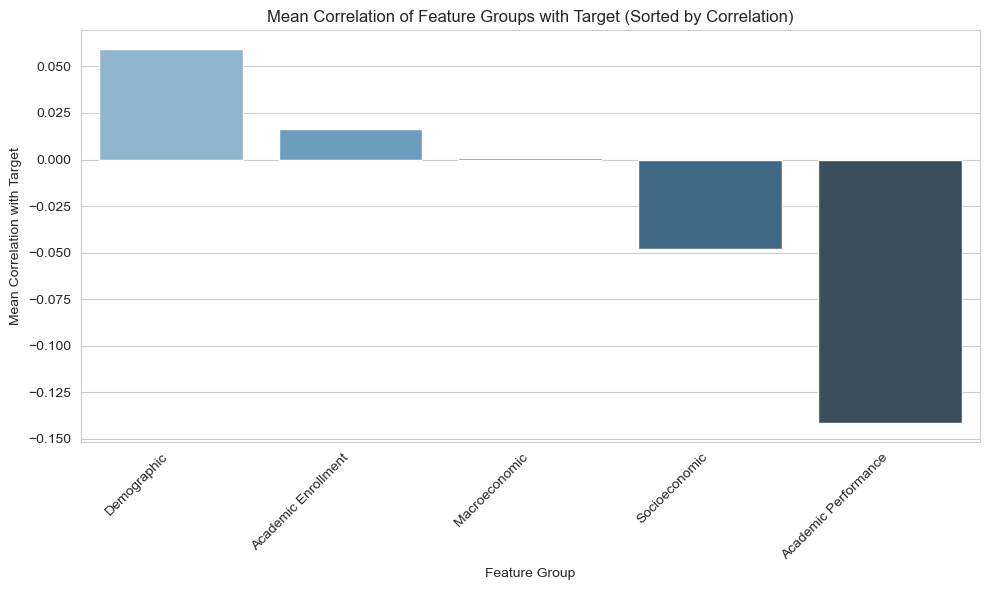

In [7]:
# Correlation of each group
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 6))
sns.barplot(x=list(sorted_category_mean_correlations.keys()), y=list(sorted_category_mean_correlations.values()), palette="Blues_d")
plt.title('Mean Correlation of Feature Groups with Target (Sorted by Correlation)')
plt.xlabel('Feature Group')
plt.ylabel('Mean Correlation with Target')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Analysis of Factors Influencing Academic Status

Based on the analysis above, we can conclude that **Academic Performance** is the most significant factor influencing an individual’s academic status, while **Macroeconomic** factors have the least impact.

1. **Academic Performance** has the strongest correlation with academic status (dropout, enrollment, or graduation), with a value close to **-0.15**.
2. **Socioeconomic factors** have a mild positive influence on the target variable. Family economic conditions and parental occupation may affect an individual’s academic status to some extent.
3. **Macroeconomic factors** show a near-zero correlation with academic status, indicating that national-level features such as unemployment and inflation rates have almost no effect on individual academic outcomes.
4. **Academic Enrollment** has a slightly negative correlation with the target variable (**0.02**). This suggests that factors related to enrollment, such as application type or course enrollment, may be associated with higher dropout rates or lower graduation rates.
5. **Demographic factors** have the lowest average correlation with the target variable among all groups, at around **0.05**. This indicates that demographic features, such as age, gender, and nationality, are negatively correlated with academic status and may be linked to higher dropout rates.

## 2. Correlation of factors in each group

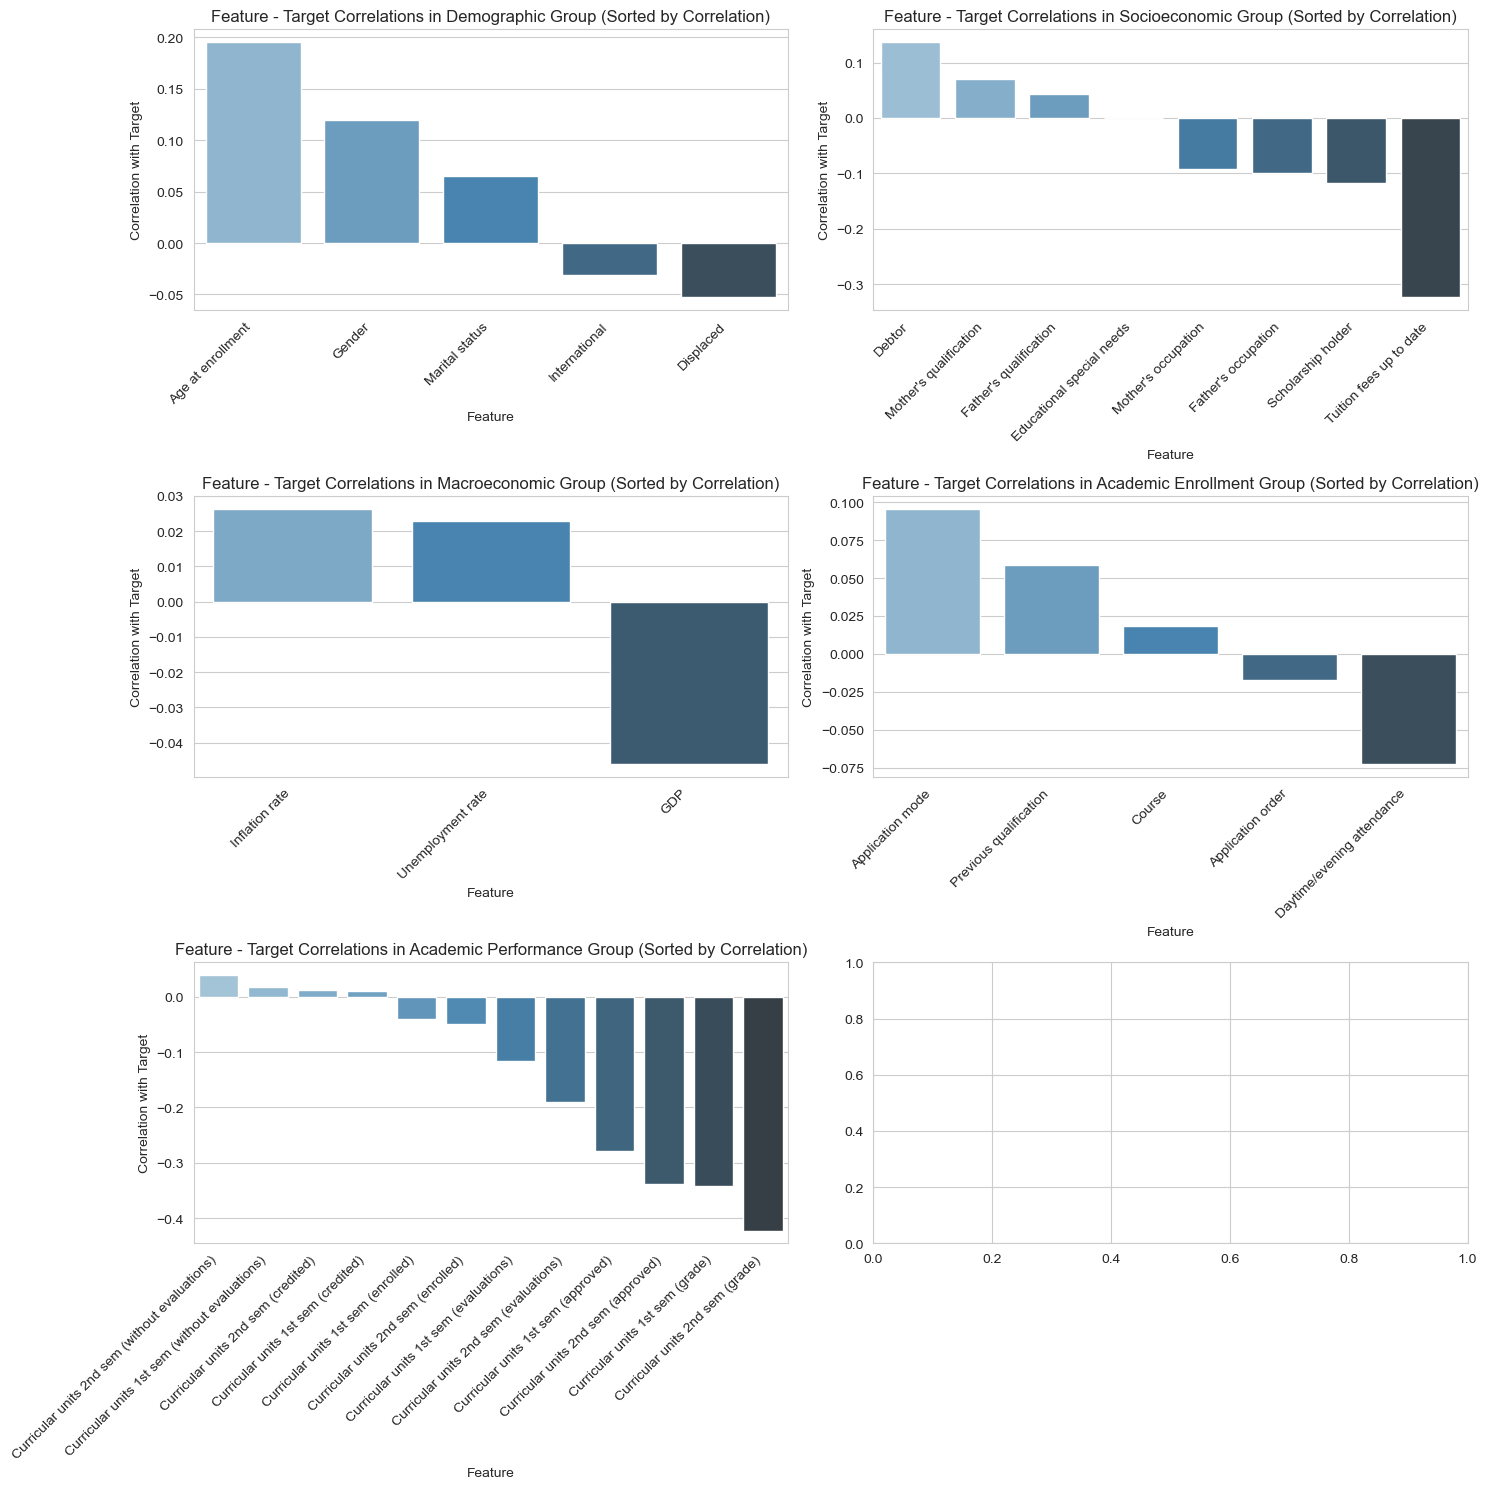

In [8]:
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (10, 5)

# Correlation of factors and target within the group
group_count = len(group_correlation_results)
# subplot col & row
row_count = (group_count + 1) // 2
col_count = 2

fig, axs = plt.subplots(row_count, col_count, figsize=(15, 5 * row_count))

if group_count <= 2:
    axs = np.array([axs])
elif row_count == 1:
    axs = axs.reshape(1, -1)
else:
    axs = axs.reshape(-1, col_count)

ax_index = 0

for group_name, correlations in group_correlation_results.items():
    # sort
    sorted_correlations = {k: v for k, v in sorted(correlations.items(), key=lambda item: item[1], reverse=True)}
    ax = axs[ax_index // col_count, ax_index % col_count]

    sns.barplot(x=list(sorted_correlations.keys()), y=list(sorted_correlations.values()), palette="Blues_d", ax=ax)
    ax.set_title(f'Feature - Target Correlations in {group_name} Group (Sorted by Correlation)')
    ax.set_xlabel('Feature')
    ax.set_ylabel('Correlation with Target')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax_index += 1

plt.tight_layout()
plt.show()

## 3. Heatmap of strong correlated fators

In [9]:
# Construct the correlation matrix
correlation_matrix = data.corr()

# Filters for features that are highly correlated with the target variable
cor_target = correlation_matrix['Target'].abs().sort_values(ascending=False)
high_corr_features = cor_target[cor_target > 0.1].index
high_corr_matrix = correlation_matrix.loc[high_corr_features, high_corr_features]

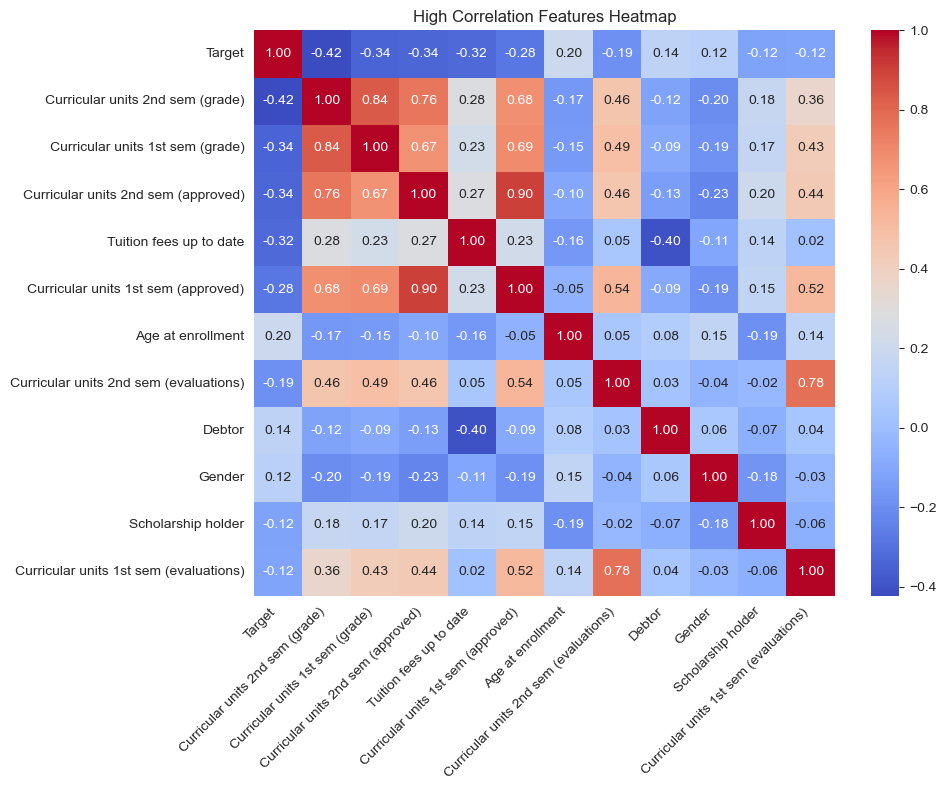

In [10]:
# Visualize the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    high_corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    cbar=True,
    xticklabels=high_corr_matrix.columns,
    yticklabels=high_corr_matrix.columns
)
plt.xticks(rotation=45, ha='right')
plt.title('High Correlation Features Heatmap', fontsize=12)
plt.tight_layout()
plt.show()

# Data preprocessing

Target
1    1778
2    1127
0     634
Name: count, dtype: int64
Index([1, 2, 0], dtype='int64', name='Target')


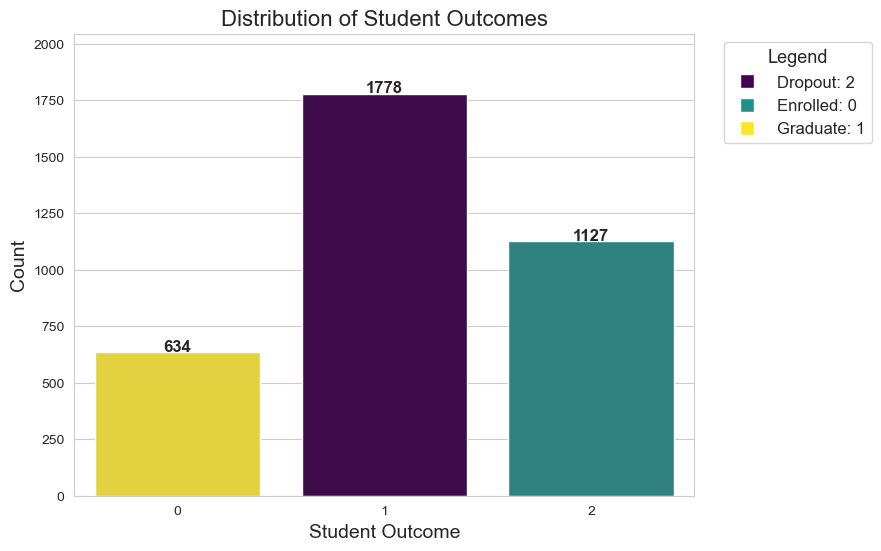

In [11]:
warnings.filterwarnings("ignore")
# Check the distribution of target
data = pd.DataFrame(data)
target_counts = data['Target'].value_counts()
print(target_counts)

print(target_counts.index)  # Check the unique values in the target column

# Define color for different targets
color_mapping = {2: '#440154', 0: '#21908C', 1: '#FDE725'}

# Visualization
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=target_counts.index, y=target_counts.values, palette=[color_mapping[i] for i in target_counts.index])

for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + 5, str(int(y)), ha='center', fontsize=12, fontweight='bold')

legend_patches = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping[key], markersize=10,
                             label=f"{label}: {key}")
                  for key, label in { 2: 'Dropout', 0: 'Enrolled', 1: 'Graduate'}.items()]
plt.legend(handles=legend_patches, title="Legend", fontsize=12, title_fontsize=13, loc='upper right', bbox_to_anchor=(1.3, 1))

plt.title('Distribution of Student Outcomes', fontsize=16)
plt.xlabel('Student Outcome', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.ylim(0, max(target_counts.values) * 1.15)

plt.show()

In [12]:
# Check the missing value
print("Missing Values:")
print(data.isnull().sum())

# Fill the missing value
for group, features in feature_groups.items():
    for feature in features:
        if feature in data.columns:
            if data[feature].dtype == 'object':
                data[feature] = data[feature].fillna(data[feature].mode()[0])
            else:
                data[feature] = data[feature].fillna(data[feature].median())

Missing Values:
ID                                                0
Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Nationality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrollment                               

In [13]:
# Feature engineering
data['1st_sem_pass_rate'] = data['Curricular units 1st sem (approved)'] / data['Curricular units 1st sem (enrolled)'].replace(0, 1)
data['2nd_sem_pass_rate'] = data['Curricular units 2nd sem (approved)'] / data['Curricular units 2nd sem (enrolled)'].replace(0, 1)
data['average_grade'] = (data['Curricular units 1st sem (grade)'] + data['Curricular units 2nd sem (grade)']) / 2
data['academic_performance_index'] = (data['1st_sem_pass_rate'] + data['2nd_sem_pass_rate']) * data['average_grade']
data['economic_stress'] = data['Debtor'] * (1 - data['Tuition fees up to date'])

In [14]:
# Outlier handling with Winsorization
def apply_winsorization(data, column, lower_percentile=0.01, upper_percentile=0.99):
    lower = np.percentile(data[column], lower_percentile * 100)
    upper = np.percentile(data[column], upper_percentile * 100)
    data[column] = np.clip(data[column], lower, upper)
    return data

numeric_features = data.select_dtypes(include=[np.number]).columns
for feature in numeric_features:
    data = apply_winsorization(data, feature)

In [15]:
X = data.drop(columns=['Target', 'ID'])
y = data['Target']

# Smote for dealing with target imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Model building


## 1. model list

In [16]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'HistGradient Boosting': HistGradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'MLP': MLPClassifier(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),

}

# Traverse the model and evaluate the performance
results = {}
for name, model in models.items():
    print(f"\nTraining model: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"Accuracy: {accuracy:.2f}")
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification report:")
    print(classification_report(y_test, y_pred))

# Accuracy of the model
print("\n Model comparison:")
for name, accuracy in results.items():
    print(f"{name}: {accuracy:.2f}")

# The best model
best_model_name = max(results, key=results.get)
print(f"\n Best performed model is: {best_model_name}, with accuracy of: {results[best_model_name]:.2f}")

best_model = models[best_model_name]


Training model: Random Forest
Accuracy: 0.84
Confusion matrix:
[[297  36  22]
 [ 29 315  12]
 [ 40  30 286]]
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       355
           1       0.83      0.88      0.85       356
           2       0.89      0.80      0.85       356

    accuracy                           0.84      1067
   macro avg       0.84      0.84      0.84      1067
weighted avg       0.84      0.84      0.84      1067


Training model: Gradient Boosting
Accuracy: 0.81
Confusion matrix:
[[279  43  33]
 [ 26 318  12]
 [ 56  28 272]]
Classification report:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       355
           1       0.82      0.89      0.85       356
           2       0.86      0.76      0.81       356

    accuracy                           0.81      1067
   macro avg       0.82      0.81      0.81      1067
weighted avg       0.82

## 2. Construct voting model with well performed models

In [17]:
# Define models
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
lgb = LGBMClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
nn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

# 1. parameters
param_grid_rf = {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15]}
param_grid_xgb = {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1, 0.2]}
param_grid_lgb = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'num_leaves': [15, 31, 50]}


param_grid_nn = {
    'hidden_layer_sizes': [(100,), (200,), (100, 100), (150, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [200, 500, 1000]
}

# RF
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_rf.fit(X_train, y_train)
print("Best RF params:", grid_rf.best_params_)

# XGB
grid_xgb = RandomizedSearchCV(xgb, param_grid_xgb, cv=3, scoring='accuracy', n_iter=5, random_state=42, n_jobs=-1)
grid_xgb.fit(X_train, y_train)
print("Best XGB params:", grid_xgb.best_params_)

# LGB
grid_lgb = GridSearchCV(lgb, param_grid_lgb, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_lgb.fit(X_train, y_train)
print("Best LGB params:", grid_lgb.best_params_)

# MLP
grid_nn = GridSearchCV(nn, param_grid_nn, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_nn.fit(X_train, y_train)
print("Best NN params:", grid_nn.best_params_)


# Best model
rf_best = grid_rf.best_estimator_
xgb_best = grid_xgb.best_estimator_
lgb_best = grid_lgb.best_estimator_
nn_best = grid_nn.best_estimator_

voting_clf = VotingClassifier(estimators=[
    ('rf', rf_best),
    ('xgb', xgb_best),
    ('lgb', lgb_best),
    ('hgb', hgb),
    ('nn', nn_best),
], voting='soft')

voting_clf.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best RF params: {'max_depth': 15, 'n_estimators': 300}
Best XGB params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2}
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3136
[LightGBM] [Info] Number of data points in the train set: 4267, number of used features: 39
[LightGBM] [Info] Start training from score -1.098144
[LightGBM] [Info] Start training from score -1.098847
[LightGBM] [Info] Start training from score -1.098847
Best LGB params: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 50}
Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best NN par

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=15,
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=...
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...)),
                             ('lgb',
                              LGBMClassifier(n_estimators=200, num_leaves=50,
                                             random_state=42)),
                             ('hgb',
                              HistGradientBoostingClassifier(random_state=42)),
                             ('nn',
                              MLPClassifier(activation='tanh',
                                            hidden_layer_sizes=(200,),
                                            max_iter=500, random_state=42))],
                 voting='soft')

In [18]:
y_pred = voting_clf.predict(X_test)
print("Voting Classifier Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Voting Classifier Accuracy: 0.8641049671977507
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86       355
           1       0.83      0.92      0.87       356
           2       0.90      0.83      0.86       356

    accuracy                           0.86      1067
   macro avg       0.87      0.86      0.86      1067
weighted avg       0.87      0.86      0.86      1067



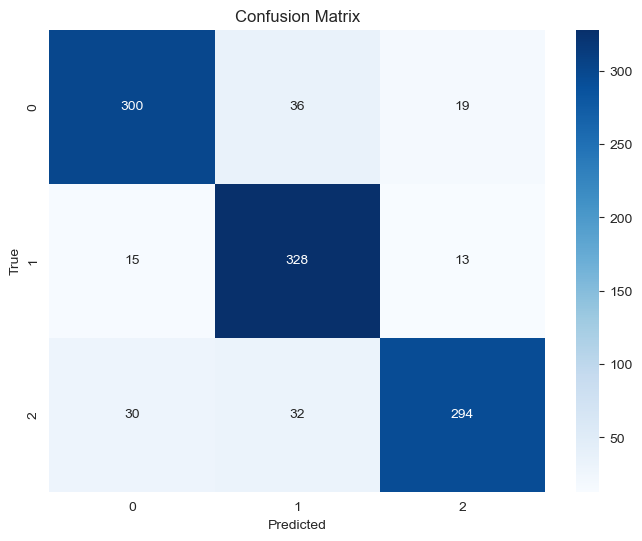

In [19]:
# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3136
[LightGBM] [Info] Number of data points in the train set: 4267, number of used features: 39
[LightGBM] [Info] Start training from score -1.098144
[LightGBM] [Info] Start training from score -1.098847
[LightGBM] [Info] Start training from score -1.098847


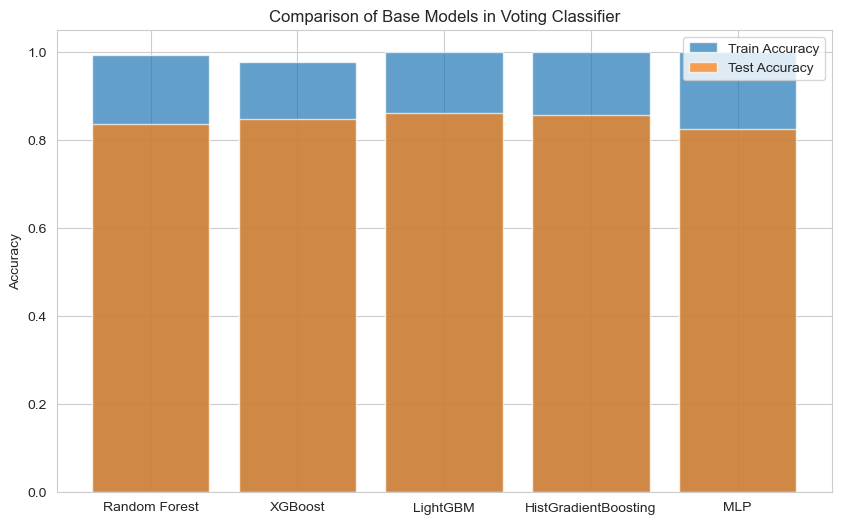

In [20]:
# Accuracy of each model
models = [rf_best, xgb_best, lgb_best,hgb, nn_best]
model_names = ['Random Forest', 'XGBoost', 'LightGBM', 'HistGradientBoosting', 'MLP']
train_accuracies = []
test_accuracies = []

for model in models:
    model.fit(X_train, y_train)
    train_accuracies.append(accuracy_score(y_train, model.predict(X_train)))
    test_accuracies.append(accuracy_score(y_test, model.predict(X_test)))

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(model_names, train_accuracies, label='Train Accuracy', alpha=0.7)
plt.bar(model_names, test_accuracies, label='Test Accuracy', alpha=0.7)
plt.ylabel('Accuracy')
plt.title('Comparison of Base Models in Voting Classifier')
plt.legend()
plt.show()

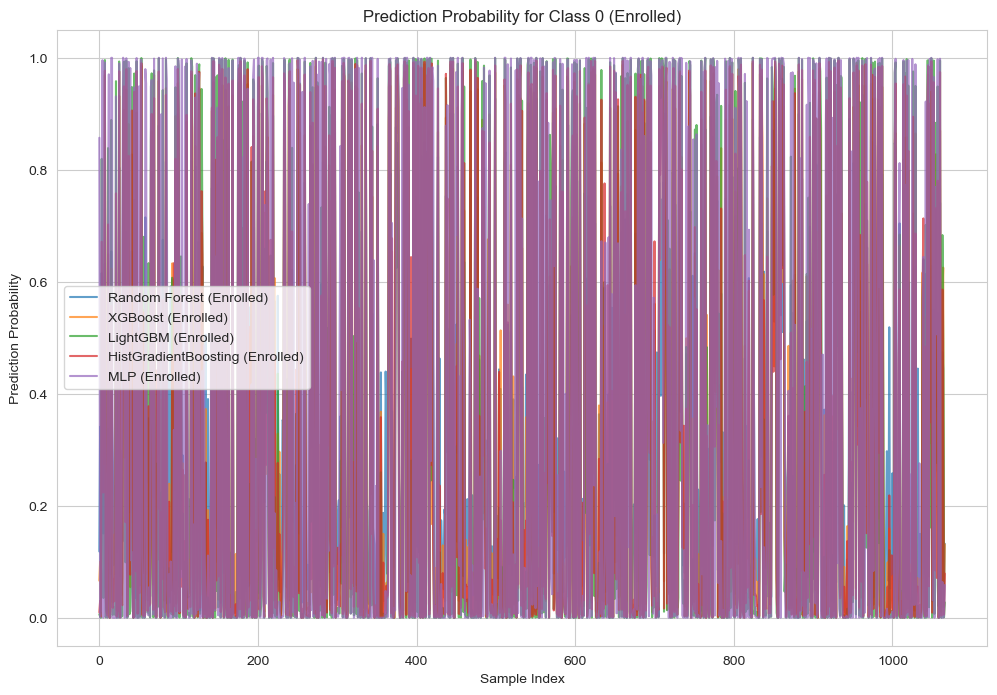

In [21]:
# Predict probability of each model
rf_probs = rf_best.predict_proba(X_test)
xgb_probs = xgb_best.predict_proba(X_test)
lgb_probs = lgb_best.predict_proba(X_test)
hgb_probs = hgb.predict_proba(X_test)
nn_probs = nn_best.predict_proba(X_test)

# The voting prob of each model
voting_probs = voting_clf.predict_proba(X_test)

# Visualize
plt.figure(figsize=(12, 8))
plt.plot(rf_probs[:, 0], label='Random Forest (Enrolled)', alpha=0.7)
plt.plot(xgb_probs[:, 0], label='XGBoost (Enrolled)', alpha=0.7)
plt.plot(lgb_probs[:, 0], label='LightGBM (Enrolled)', alpha=0.7)
plt.plot(hgb_probs[:, 0], label='HistGradientBoosting (Enrolled)', alpha=0.7)
plt.plot(nn_probs[:, 0], label='MLP (Enrolled)', alpha=0.7)
#plt.plot(voting_probs[:, 0], label='Voting Classifier (Enrolled)', alpha=1.0, linewidth=2)

plt.legend()
plt.title('Prediction Probability for Class 0 (Enrolled)')
plt.xlabel('Sample Index')
plt.ylabel('Prediction Probability')
plt.show()

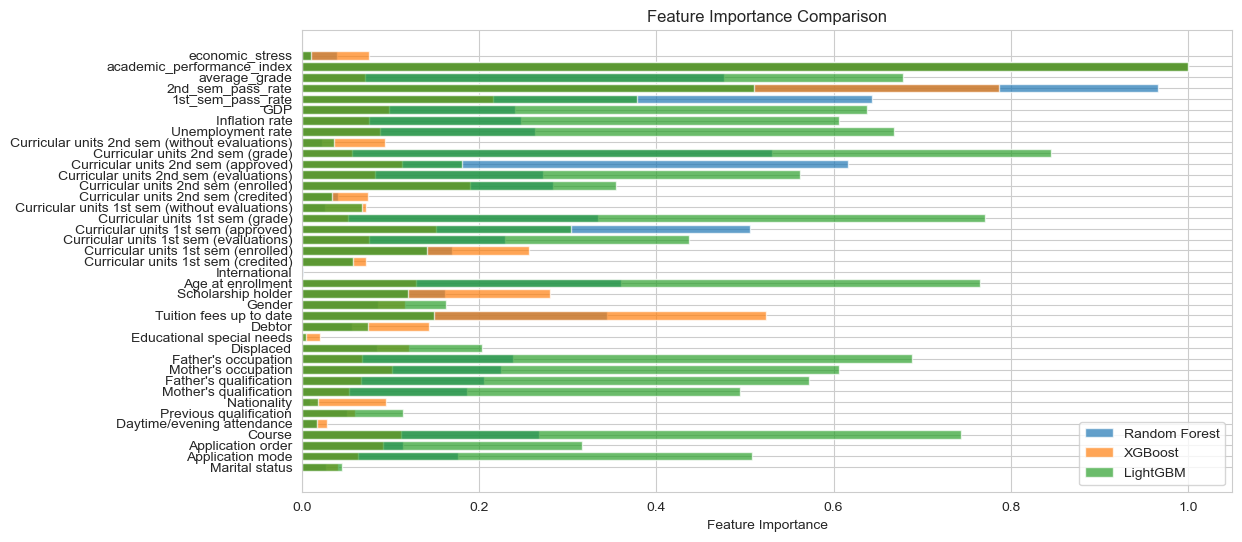

In [22]:
# Feature importance
rf_importance = rf_best.feature_importances_
xgb_importance = xgb_best.feature_importances_
lgb_importance = lgb_best.feature_importances_

# Normalization
rf_importance_norm = (rf_importance - np.min(rf_importance)) / (np.max(rf_importance) - np.min(rf_importance))
xgb_importance_norm = (xgb_importance - np.min(xgb_importance)) / (np.max(xgb_importance) - np.min(xgb_importance))
lgb_importance_norm = (lgb_importance - np.min(lgb_importance)) / (np.max(lgb_importance) - np.min(lgb_importance))
feature_names = X_train.columns

plt.figure(figsize=(12, 6))
plt.barh(feature_names, rf_importance_norm, label='Random Forest', alpha=0.7)
plt.barh(feature_names, xgb_importance_norm, label='XGBoost', alpha=0.7)
plt.barh(feature_names, lgb_importance_norm, label='LightGBM', alpha=0.7)

plt.xlabel('Feature Importance')
plt.title('Feature Importance Comparison')
plt.legend()
plt.show()

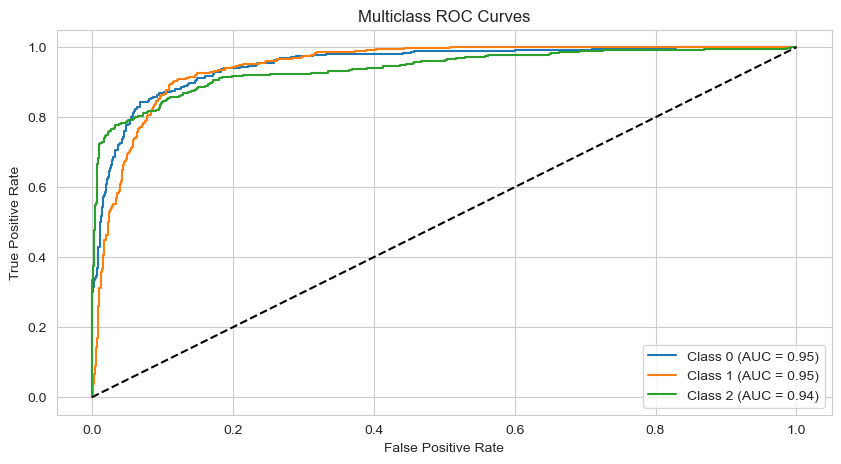

In [23]:
# Visualize the ROC curve
classes = np.unique(y_test)
for i in range(len(classes)):
    class_i = classes[i]
    other_classes = np.delete(classes, i)
    y_test_binary = np.where(y_test == class_i, 1, 0)
    y_pred_proba_i = model.predict_proba(X_test)[:, i]
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba_i)
    auc_score = roc_auc_score(y_test_binary, y_pred_proba_i)
    plt.plot(fpr, tpr, label=f'Class {class_i} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend()
plt.show()

## 4. Predict the test set

In [25]:
# Upload Test dataset
test_file_path = 'Original data/test.csv'
test_data = pd.read_csv(test_file_path)

# 保存测试集的ID列，以便后续使用
test_ids = test_data['ID']

In [26]:
# Same feature engineering
test_data['1st_sem_pass_rate'] = test_data['Curricular units 1st sem (approved)'] / test_data['Curricular units 1st sem (enrolled)'].replace(0, 1)
test_data['2nd_sem_pass_rate'] = test_data['Curricular units 2nd sem (approved)'] / test_data['Curricular units 2nd sem (enrolled)'].replace(0, 1)
test_data['average_grade'] = (test_data['Curricular units 1st sem (grade)'] + test_data['Curricular units 2nd sem (grade)']) / 2
test_data['academic_performance_index'] = (test_data['1st_sem_pass_rate'] + test_data['2nd_sem_pass_rate']) * test_data['average_grade']
test_data['economic_stress'] = test_data['Debtor'] * (1 - test_data['Tuition fees up to date'])

In [27]:
# Outlier handling with Winsorization
for feature in numeric_features:
    test_data = apply_winsorization(test_data, feature)

# Extract the features for prediction
X_test_final = test_data.drop(columns=['ID'], errors='ignore')  # 这里保留ID，以便后续输出
if 'Target' in X_test_final.columns:
    X_test_final = X_test_final.drop(columns=['Target'])

In [28]:
test_predictions = voting_clf.predict(X_test_final)

# Define corresponding reverse map
reverse_map = {1: 'Graduate', 0: 'Enrolled', 2: 'Dropout'}

# Reverse map for each element of the result
test_predictions = [reverse_map.get(prediction, prediction) for prediction in test_predictions]

# Store
output = pd.DataFrame({'ID': test_ids, 'Target': test_predictions})  # 使用保留的test_ids
output_file_path = 'Original data/test_predictresult 7.csv'
output.to_csv(output_file_path, index=False)

print(f"Predict result stored to {output_file_path}")

Predict result stored to Original data/test_predictresult 7.csv
